The objective of this work is to develop a convolutional neural network for the classification of images of potato leaves, in order to accurately and quickly identify whether the leaves are diseased with late blight, early blight or if they are healthy.

In [2]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

The dataset contains images of leaves with early blight, late blight and healthy leaves, separated into three sets Training, Testing and Validation
The dataset is balanced, with 1628 images of early blight, 1414 images of late blight and 1020 images of healthy leaves. A total of 4062 images

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Training',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Testing',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Validation',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


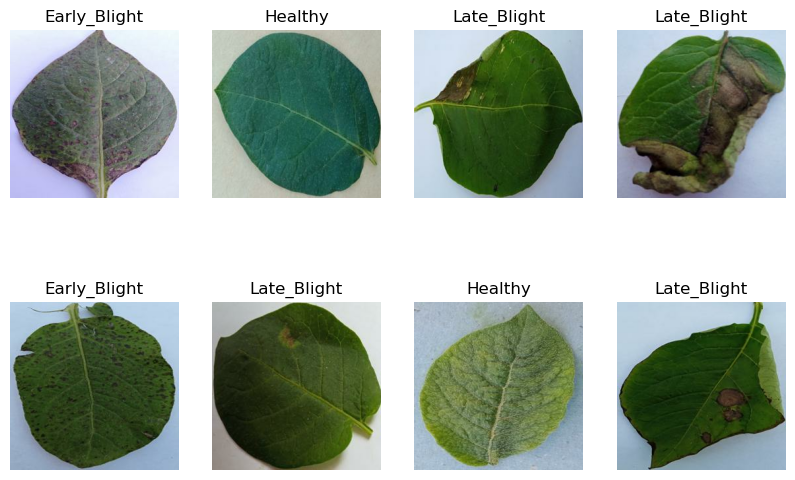

In [4]:
class_names = training_dataset.class_names

plt.figure(figsize=(10,10))
for image_batch,label_batch in training_dataset.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


Data augmentation is a key technique to increase the diversity of the training data set and prevent overfitting. Different data augmentation techniques were applied using the Keras library and its ImageDataGenerator method.

- Pixel Scaling: To reduce computational cost, the pixel values ​​of all images were scaled to a range of 0 to 1, dividing each value by 255.

- Rotation: Images were randomly rotated by a 20 degree angle to introduce variations in orientation.

- Scrolling: A random horizontal and vertical scrolling was applied to the images. Horizontal scrolling was performed with a maximum range of 10% of the image width, and vertical scrolling was performed with a maximum range of 10% of the image height.

- Horizontal and Vertical Flip: Images were randomly flipped horizontally and vertically to create mirrored versions.

In [5]:

data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Training dataset with data augmentation
train_data_gen = data_augmentation.flow_from_directory(
    directory='images/Training',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Use only the training samples
)


Found 3251 images belonging to 3 classes.


In [6]:
x_val_data = list()
y_val_data = list()
for image_batch, label_batch in validation_dataset:
    x_val_data.append(image_batch[0].numpy())
    y_val_data.append(label_batch[0].numpy())

# Convertir listas a matrices NumPy
val_images = np.array(x_val_data)
Y_val = np.array(y_val_data)


# Normalizamos las imágenes
X_val = val_images.astype('uint32') / 255

label_encoder = LabelEncoder()

encoded_val_labels = label_encoder.fit_transform(Y_val)
Y_val = np_utils.to_categorical(encoded_val_labels, 3)

x_testing_data = list()
y_testing_data = list()
for image_batch, label_batch in testing_dataset:
    x_testing_data.append(image_batch[0].numpy())
    y_testing_data.append(label_batch[0].numpy())

# Convertir listas a matrices NumPy
testing_images = np.array(x_testing_data)
Y_testing = np.array(y_testing_data)

# Normalizamos las imágenes
X_testing = testing_images.astype('uint32') / 255

encoded_training_labels = label_encoder.fit_transform(Y_testing)
Y_testing = np_utils.to_categorical(encoded_training_labels, 3)


In [7]:
model = Sequential()

# 1st CNN layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th CNN layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(len(class_names), activation='softmax'))


In [8]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 4,325,507
Trainable params: 4,325,251
Non-trainable params: 25

In [9]:
batch_size=64
epochs=50

history = model.fit(train_data_gen,
                    epochs=epochs,  
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=1)

Epoch 1/50
102/102 [==============================] - 156s 2s/step - loss: 0.8925 - accuracy: 0.6210 - val_loss: 1.0350 - val_accuracy: 0.4615
Epoch 2/50
102/102 [==============================] - 143s 1s/step - loss: 0.6539 - accuracy: 0.7358 - val_loss: 0.9688 - val_accuracy: 0.6154
Epoch 3/50
102/102 [==============================] - 143s 1s/step - loss: 0.5714 - accuracy: 0.7751 - val_loss: 0.8745 - val_accuracy: 0.5385
Epoch 4/50
102/102 [==============================] - 145s 1s/step - loss: 0.5304 - accuracy: 0.7890 - val_loss: 0.7734 - val_accuracy: 0.6923
Epoch 5/50
102/102 [==============================] - 144s 1s/step - loss: 0.4700 - accuracy: 0.8164 - val_loss: 0.6394 - val_accuracy: 0.6923
Epoch 6/50
102/102 [==============================] - 149s 1s/step - loss: 0.4181 - accuracy: 0.8474 - val_loss: 1.0820 - val_accuracy: 0.6154
Epoch 7/50
102/102 [==============================] - 146s 1s/step - loss: 0.4058 - accuracy: 0.8474 - val_loss: 0.5201 - val_accuracy: 0.6923

1/1 [==============================] - 0s 146ms/step - loss: 0.0849 - accuracy: 0.9231
Test loss: 0.08493522554636002
Test accuracy: 0.9230769276618958


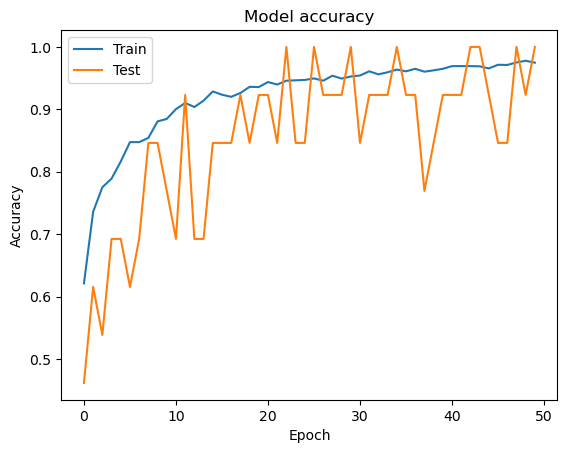

In [10]:
score = model.evaluate(X_testing, Y_testing, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
for image_batch, label_batch in testing_dataset.take(5):
    print("The Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])

The Image Title :  Healthy
1/1 [==============================] - 1s 832ms/step
Model Predicted label :  Late_Blight
The Image Title :  Late_Blight
1/1 [==============================] - 0s 272ms/step
Model Predicted label :  Late_Blight
The Image Title :  Early_Blight
1/1 [==============================] - 0s 272ms/step
Model Predicted label :  Late_Blight
The Image Title :  Early_Blight
1/1 [==============================] - 0s 280ms/step
Model Predicted label :  Early_Blight
The Image Title :  Early_Blight
1/1 [==============================] - 0s 283ms/step
Model Predicted label :  Early_Blight
